# Isolation Forest on PCA space

Unsupervised anomaly detection tuned on the PCA outputs.


## Imports and plotting defaults


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
  accuracy_score,
  classification_report,
  confusion_matrix,
  precision_score,
  recall_score,
  f1_score,
  roc_auc_score,
  roc_curve,
)
from sklearn.model_selection import train_test_split, ParameterGrid

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

DATA_DIR = Path('../data')
RANDOM_STATE = 42

## Load PCA datasets

Pull the saved PCA projections. Run the PCA notebook first if these files are missing.


In [ ]:
train_path = DATA_DIR / 'pca_kdd_train.csv'
test_path = DATA_DIR / 'pca_kdd_test.csv'
if not train_path.exists() or not test_path.exists():
  raise FileNotFoundError(
    'Run the PCA notebook to create the PCA-nsl_kdd CSV files first.'
  )

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
label_col = 'attack_flag' if 'attack_flag' in train_df.columns else 'attack_type'
feature_cols = [col for col in train_df.columns if col != label_col]

X_train_pca = train_df[feature_cols].to_numpy()
X_test_pca = test_df[feature_cols].to_numpy()
if label_col == 'attack_flag':
  y_train = train_df[label_col].astype(int).to_numpy()
  y_test = test_df[label_col].astype(int).to_numpy()
else:
  y_train = (train_df[label_col] != 'normal').astype(int).to_numpy()
  y_test = (test_df[label_col] != 'normal').astype(int).to_numpy()

print(f'PCA feature shape (train/test): {X_train_pca.shape} / {X_test_pca.shape}')
print(f'Attack rate train/test: {y_train.mean():.2%} / {y_test.mean():.2%}')


PCA feature shape (train/test): (125973, 18) / (22544, 18)
Attack rate train/test: 46.54% / 56.92%


## Isolation Forest validation split

Hold out part of the training data to tune hyperparameters.


In [ ]:
X_if_train, X_if_val, y_if_train, y_if_val = train_test_split(
  X_train_pca, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

print(
  f'Isolation Forest train size: {X_if_train.shape[0]} | validation size: {X_if_val.shape[0]}'
)

Isolation Forest train size: 100778 | validation size: 25195


## Hyperparameter sweep


In [ ]:
attack_rate = y_train.mean()
contamination_candidates = [
  max(0.01, attack_rate * 0.6),
  max(0.01, attack_rate * 0.8),
  max(0.01, attack_rate),
  max(0.01, min(0.5, attack_rate * 1.2)),
]
contamination_values = sorted({round(min(0.5, c), 4) for c in contamination_candidates})

param_grid = {
  'n_estimators': [256, 512],
  'max_samples': [0.6, 0.9],
  'contamination': contamination_values,
}

search_results = []
for params in ParameterGrid(param_grid):
  model = IsolationForest(random_state=RANDOM_STATE, n_jobs=-1, **params)
  model.fit(X_if_train)
  val_scores = -model.decision_function(X_if_val)
  val_preds = (model.predict(X_if_val) == -1).astype(int)

  search_results.append(
    {
      'n_estimators': params['n_estimators'],
      'max_samples': params['max_samples'],
      'contamination': round(params['contamination'], 4),
      'precision': precision_score(y_if_val, val_preds),
      'recall': recall_score(y_if_val, val_preds),
      'f1': f1_score(y_if_val, val_preds),
      'roc_auc': roc_auc_score(y_if_val, val_scores),
    }
  )

results_df = (
  pd.DataFrame(search_results).sort_values('f1', ascending=False).reset_index(drop=True)
)
results_df

,n_estimators,max_samples,contamination,precision,recall,f1,roc_auc
0,512,0.9,0.5000,0.559198,0.603786,0.580637,0.690036
1,512,0.9,0.4654,0.563113,0.567627,0.565361,0.690036
2,256,0.6,0.5000,0.544147,0.587071,0.564795,0.692776
3,256,0.9,0.5000,0.538589,0.582040,0.559472,0.672019
4,512,0.6,0.5000,0.535052,0.575388,0.554487,0.689103
5,256,0.9,0.4654,0.551022,0.553983,0.552498,0.672019
6,256,0.6,0.4654,0.550102,0.554324,0.552205,0.692776
7,512,0.6,0.4654,0.547131,0.548951,0.548040,0.689103
8,256,0.6,0.3723,0.591735,0.477486,0.528507,0.692776
9,512,0.9,0.3723,0.589097,0.476463,0.526827,0.690036


## Train final Isolation Forest & evaluate


In [ ]:
best_row = results_df.iloc[0]
best_params = {
  'n_estimators': int(best_row['n_estimators']),
  'max_samples': float(best_row['max_samples']),
  'contamination': float(best_row['contamination']),
}

print(f'Best hyperparameters: {best_params}')

best_model = IsolationForest(random_state=RANDOM_STATE, n_jobs=-1, **best_params)
best_model.fit(X_train_pca)

# Calculate scores and predictions once for all subsequent analyses
train_scores = -best_model.decision_function(X_train_pca)
test_scores = -best_model.decision_function(X_test_pca)
train_preds = (best_model.predict(X_train_pca) == -1).astype(int)
test_preds = (best_model.predict(X_test_pca) == -1).astype(int)


def evaluate_split(name, y, preds, scores):
  print(f'[{name}] attack share: {y.mean():.2%}')
  print(classification_report(y, preds, target_names=['Normal', 'Attack']))
  print('ROC-AUC:', roc_auc_score(y, scores))
  print('Confusion matrix:', confusion_matrix(y, preds))
  print('-' * 60)


evaluate_split('Train', y_train, train_preds, train_scores)
evaluate_split('Test', y_test, test_preds, test_scores)

Best hyperparameters: {'n_estimators': 512, 'max_samples': 0.9, 'contamination': 0.5}
[Train] attack share: 46.54%
              precision    recall  f1-score   support

      Normal       0.61      0.57      0.59     67343
      Attack       0.54      0.58      0.56     58630

    accuracy                           0.57    125973
   macro avg       0.57      0.57      0.57    125973
weighted avg       0.57      0.57      0.57    125973

ROC-AUC: 0.6879700595652568
Confusion matrix: [[38153 29190]
 [24834 33796]]
------------------------------------------------------------
[Test] attack share: 56.92%
              precision    recall  f1-score   support

      Normal       0.78      0.71      0.74      9711
      Attack       0.79      0.85      0.82     12833

    accuracy                           0.79     22544
   macro avg       0.79      0.78      0.78     22544
weighted avg       0.79      0.79      0.79     22544

ROC-AUC: 0.8760136783399476
Confusion matrix: [[ 6849  2862]
 [ 1

## Metric comparison summary

A consolidated table that reports Accuracy, Precision, Recall, F1, and ROC-AUC for the Isolation Forest on the training (before) and test (after) splits, matching the evaluation dimensions requested by the team.


In [ ]:
def summarize_split(name, y, preds, scores):
  return {
    'split': name,
    'accuracy': accuracy_score(y, preds),
    'precision': precision_score(y, preds),
    'recall': recall_score(y, preds),
    'f1': f1_score(y, preds),
    'roc_auc': roc_auc_score(y, scores),
  }


metric_summary = pd.DataFrame(
  [
    summarize_split('Before (train)', y_train, train_preds, train_scores),
    summarize_split('After (test)', y_test, test_preds, test_scores),
  ]
).set_index('split')

print('Isolation Forest metrics by split (higher is better)')
display(metric_summary.round(3))

Isolation Forest metrics by split (higher is better)


,accuracy,precision,recall,f1,roc_auc
split,,,,,
Before (train),0.571,0.537,0.576,0.556,0.688
After (test),0.787,0.792,0.849,0.819,0.876


## Threshold analysis (normal vs attack)


In [ ]:
contamination = best_params['contamination']
threshold = float(np.quantile(train_scores, 1 - contamination))

print(
  f'--- Threshold Analysis (top {contamination:.2%} of anomaly scores flagged as attack) ---\n'
)


def describe_split(name, scores, labels):
  labels = labels.to_numpy() if hasattr(labels, 'to_numpy') else labels
  normal_mask = labels == 0
  attack_mask = labels == 1

  normal_above = int((scores[normal_mask] > threshold).sum())
  normal_below = int((scores[normal_mask] <= threshold).sum())
  attack_above = int((scores[attack_mask] > threshold).sum())
  attack_below = int((scores[attack_mask] <= threshold).sum())

  total_normal = normal_mask.sum()
  total_attack = attack_mask.sum()

  print(f'{name} split (threshold = {threshold:.4f}):')
  print(
    f'  Normal traffic  -> Above: {normal_above:,} ({normal_above / total_normal:.1%}), '
    f'Below: {normal_below:,} ({normal_below / total_normal:.1%})'
  )
  print(
    f'  Attack traffic  -> Above: {attack_above:,} ({attack_above / total_attack:.1%}), '
    f'Below: {attack_below:,} ({attack_below / total_attack:.1%})\n'
  )

  summary = pd.DataFrame(
    [
      (name, 'Normal', 'Allowed (normal)', normal_below, normal_below / total_normal),
      (name, 'Normal', 'Blocked (attack)', normal_above, normal_above / total_normal),
      (name, 'Attack', 'Allowed (normal)', attack_below, attack_below / total_attack),
      (name, 'Attack', 'Blocked (attack)', attack_above, attack_above / total_attack),
    ],
    columns=['split', 'actual', 'decision', 'count', 'share'],
  )
  summary['threshold'] = threshold
  summary['share_pct'] = (summary['share'] * 100).round(1)
  return summary[
    ['split', 'threshold', 'actual', 'decision', 'count', 'share', 'share_pct']
  ]


train_threshold_df = describe_split('Before (train)', train_scores, y_train)
test_threshold_df = describe_split('After (test)', test_scores, y_test)
threshold_summary = pd.concat(
  [train_threshold_df, test_threshold_df], ignore_index=True
)
threshold_summary

--- Threshold Analysis (top 50.00% of anomaly scores flagged as attack) ---

Before (train) split (threshold = 0.0000):
  Normal traffic  -> Above: 29,190 (43.3%), Below: 38,153 (56.7%)
  Attack traffic  -> Above: 33,796 (57.6%), Below: 24,834 (42.4%)

After (test) split (threshold = 0.0000):
  Normal traffic  -> Above: 2,862 (29.5%), Below: 6,849 (70.5%)
  Attack traffic  -> Above: 10,889 (84.9%), Below: 1,944 (15.1%)



,split,threshold,actual,decision,count,share,share_pct
0,Before (train),0.0,Normal,Allowed (normal),38153,0.566547,56.7
1,Before (train),0.0,Normal,Blocked (attack),29190,0.433453,43.3
2,Before (train),0.0,Attack,Allowed (normal),24834,0.423572,42.4
3,Before (train),0.0,Attack,Blocked (attack),33796,0.576428,57.6
4,After (test),0.0,Normal,Allowed (normal),6849,0.705283,70.5
5,After (test),0.0,Normal,Blocked (attack),2862,0.294717,29.5
6,After (test),0.0,Attack,Allowed (normal),1944,0.151484,15.1
7,After (test),0.0,Attack,Blocked (attack),10889,0.848516,84.9


## Attack passage rates

Summarizes what percentage (and count) of attack flows are blocked vs allowed before and after deployment, so stakeholders can quote "attacks getting through" directly.


In [ ]:
attack_rows = threshold_summary[threshold_summary['actual'] == 'Attack'].copy()
attack_rows['decision'] = attack_rows['decision'].map(
  {'Blocked (attack)': 'Blocked (flagged)', 'Allowed (normal)': 'Allowed through'}
)
attack_rows['split'] = (
  attack_rows['split']
  .str.replace('Train', 'Before (train)')
  .str.replace('Test', 'After (test)')
)

attack_pct = attack_rows.pivot(
  index='split', columns='decision', values='share_pct'
).rename(columns=str.title)
attack_counts = attack_rows.pivot(index='split', columns='decision', values='count')

attack_summary = pd.concat(
  {'percent': attack_pct.round(1), 'count': attack_counts.astype(int)}, axis=1
)

print('Attack flows: percentage and counts above/below threshold')
display(attack_summary)

for split, row in attack_rows.groupby('split'):
  allowed = row[row['decision'] == 'Allowed through']['share_pct'].iloc[0]
  blocked = row[row['decision'] == 'Blocked (flagged)']['share_pct'].iloc[0]
  print(f'{split}: {blocked:.1f}% of attacks flagged, {allowed:.1f}% slip through')


Attack flows: percentage and counts above/below threshold


percent                             count  \
decision       Allowed Through Blocked (Flagged) Allowed through   
split                                                              
After (test)              15.1              84.9            1944   
Before (train)            42.4              57.6           24834   

                                  
decision       Blocked (flagged)  
split                             
After (test)               10889  
Before (train)             33796

After (test): 84.9% of attacks flagged, 15.1% slip through
Before (train): 57.6% of attacks flagged, 42.4% slip through


## Threshold visualization

Plot anomaly scores for every record (train/test) sorted by score, and overlay the adaptive threshold derived from the contamination rate.


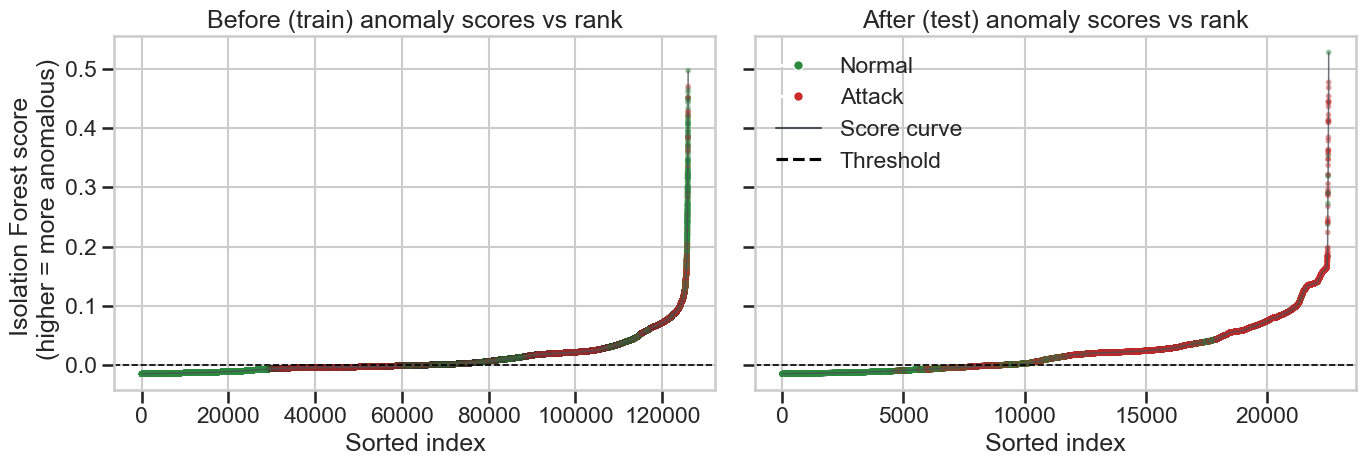

In [ ]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

split_payload = [
  ('Before (train)', train_scores, y_train),
  ('After (test)', test_scores, y_test),
]

for ax, (name, scores, labels) in zip(axes, split_payload):
  label_array = labels if isinstance(labels, np.ndarray) else labels.to_numpy()
  order = np.argsort(scores)
  ordered_scores = scores[order]
  ordered_labels = label_array[order]
  colors = np.where(ordered_labels == 1, '#c92a2a', '#2b8a3e')
  x_idx = np.arange(len(ordered_scores))

  ax.scatter(x_idx, ordered_scores, c=colors, s=8, alpha=0.35)
  ax.plot(x_idx, ordered_scores, color='#495057', linewidth=1.1, alpha=0.8)
  ax.axhline(threshold, color='black', linestyle='--', linewidth=1.2)
  ax.set_title(f'{name} anomaly scores vs rank')
  ax.set_xlabel('Sorted index')

axes[0].set_ylabel('Isolation Forest score \n (higher = more anomalous)')

legend_handles = [
  Line2D(
    [0],
    [0],
    marker='o',
    color='w',
    label='Normal',
    markerfacecolor='#2b8a3e',
    markersize=7,
  ),
  Line2D(
    [0],
    [0],
    marker='o',
    color='w',
    label='Attack',
    markerfacecolor='#c92a2a',
    markersize=7,
  ),
  Line2D([0], [0], color='#495057', linewidth=1.5, label='Score curve'),
  Line2D([0], [0], color='black', linestyle='--', label='Threshold'),
]
axes[1].legend(handles=legend_handles, loc='best')

plt.tight_layout()
plt.show()


## Diagnostics & visualization


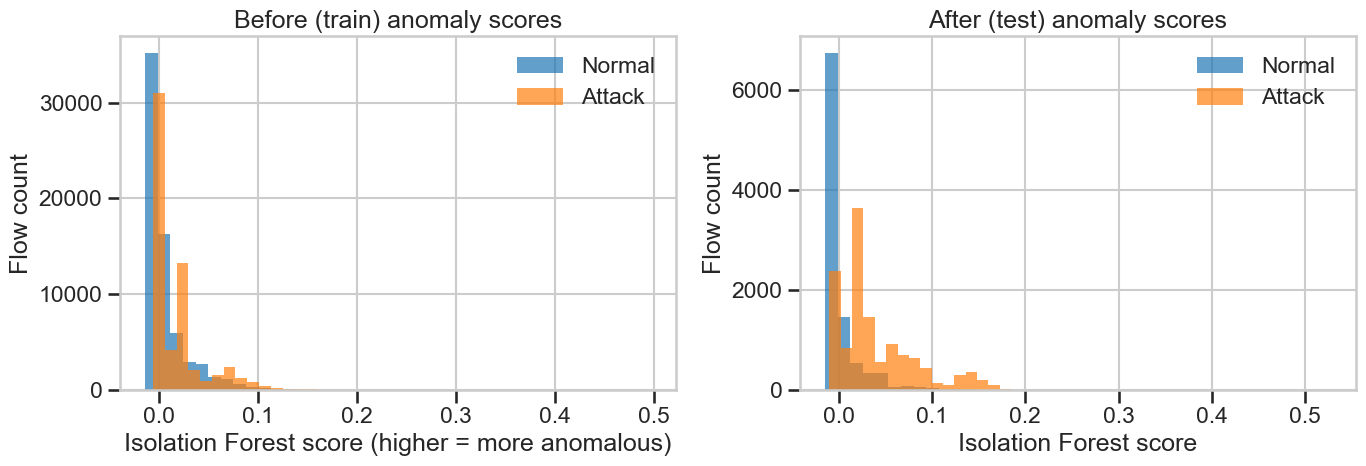

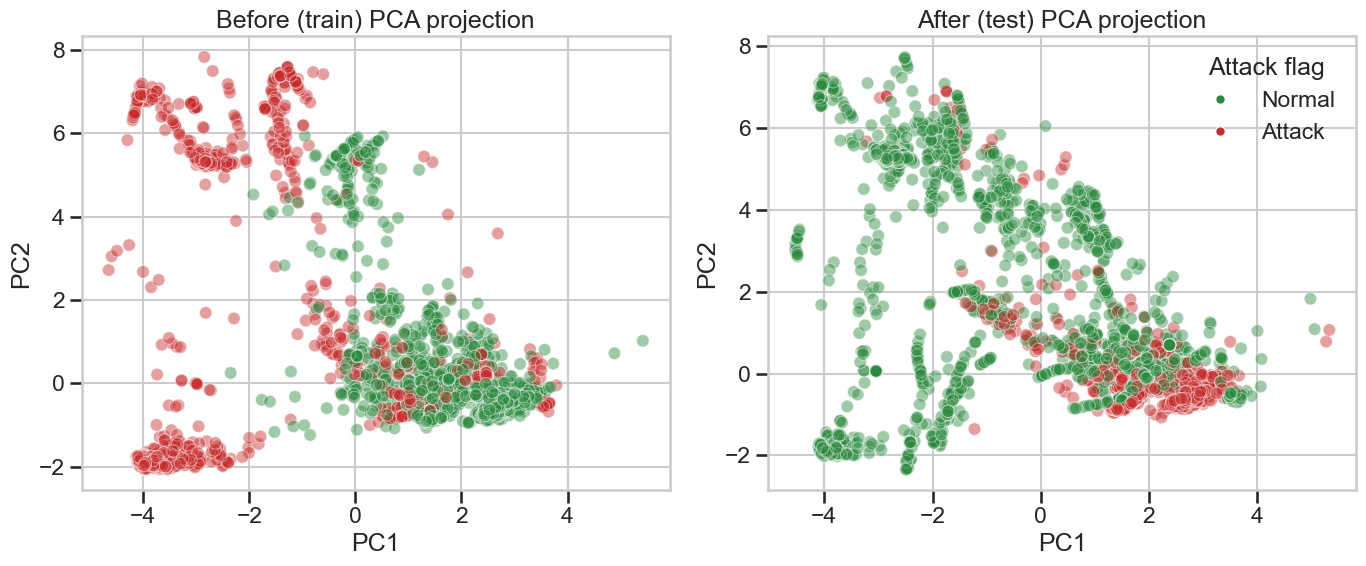

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(train_scores[y_train == 0], bins=40, alpha=0.7, label='Normal')
axes[0].hist(train_scores[y_train == 1], bins=40, alpha=0.7, label='Attack')
axes[0].set_title('Before (train) anomaly scores')
axes[0].set_xlabel('Isolation Forest score (higher = more anomalous)')
axes[0].set_ylabel('Flow count')
axes[0].legend()

axes[1].hist(test_scores[y_test == 0], bins=40, alpha=0.7, label='Normal')
axes[1].hist(test_scores[y_test == 1], bins=40, alpha=0.7, label='Attack')
axes[1].set_title('After (test) anomaly scores')
axes[1].set_xlabel('Isolation Forest score')
axes[1].set_ylabel('Flow count')
axes[1].legend()

plt.tight_layout()
plt.show()

rng = np.random.default_rng(RANDOM_STATE)
scatter_payload = [
  ('Before (train)', X_train_pca, y_train),
  ('After (test)', X_test_pca, y_test),
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, (name, X, labels) in zip(axes, scatter_payload):
  subset = min(6000, X.shape[0])
  idx = rng.choice(X.shape[0], size=subset, replace=False)
  label_array = labels if isinstance(labels, np.ndarray) else labels.to_numpy()
  scatter_df = pd.DataFrame(
    {'pc1': X[idx, 0], 'pc2': X[idx, 1], 'label': label_array[idx]}
  )
  scatter_df['label_name'] = scatter_df['label'].map({0: 'Normal', 1: 'Attack'})

  sns.scatterplot(
    data=scatter_df,
    x='pc1',
    y='pc2',
    hue='label_name',
    palette=['#2b8a3e', '#c92a2a'],
    alpha=0.45,
    ax=ax,
    legend=False,
  )
  ax.set_title(f'{name} PCA projection')
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')

handles = [
  Line2D(
    [0],
    [0],
    marker='o',
    color='w',
    label='Normal',
    markerfacecolor='#2b8a3e',
    markersize=7,
  ),
  Line2D(
    [0],
    [0],
    marker='o',
    color='w',
    label='Attack',
    markerfacecolor='#c92a2a',
    markersize=7,
  ),
]
axes[-1].legend(handles=handles, title='Attack flag', loc='best')
plt.tight_layout()
plt.show()

_Figure notes:_ The threshold plot overlays (sorted anomaly scores plus dashed cutoff) and the PCA scatter grids (before vs after) translate the numeric metrics into visuals, showing exactly where normals/attacks sit relative to the learned boundary.


## ROC-AUC Curve


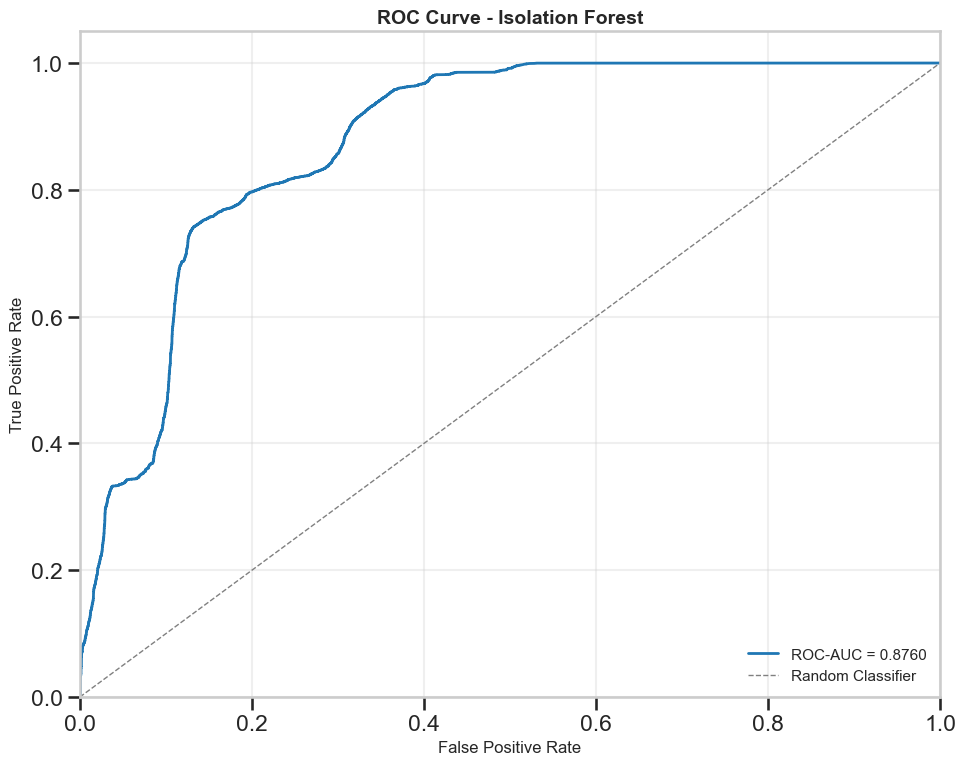

In [13]:
# Calculate ROC curve for test set
test_fpr, test_tpr, _ = roc_curve(y_test, test_scores)
test_roc_auc = roc_auc_score(y_test, test_scores)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(test_fpr, test_tpr, color='#1f77b4', lw=2, 
        label=f'ROC-AUC = {test_roc_auc:.4f}')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Isolation Forest', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Final Classification Metrics (Test Set)


In [14]:
# Calculate final metrics for test set
test_precision = precision_score(y_test, test_preds)
test_recall = recall_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds)
test_roc_auc = roc_auc_score(y_test, test_scores)

print('--- Classification Metrics ---')
print(f'Precision: {test_precision:.4f}')
print(f'Recall:    {test_recall:.4f}')
print(f'F1 Score:  {test_f1:.4f}')
print(f'ROC-AUC:   {test_roc_auc:.4f}')

--- Classification Metrics ---
Precision: 0.7919
Recall:    0.8485
F1 Score:  0.8192
ROC-AUC:   0.8760
